In [2]:
%load_ext autoreload
%autoreload 2

import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
import polars as pl

from tqdm import tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=False)

from dataclasses import dataclass
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()
sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *

plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True
                     })

In [1]:
# with uproot.open('/home/pgranger/atmospherics/sum_50k_hd_AV.root') as f:
filename='merged_caf_pfpfix_hd.parquet'
filepath='/home/henrique/Documents/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/'
# load_caf(f'{filepath}{filename}', True)
dfnew = pl.read_parquet(f'{filepath}{filename}')

NameError: name 'pl' is not defined

In [4]:
dfold = pl.read_parquet('/home/henrique/Documents/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/flatcaf_sum_300k_new2.parquet')

In [5]:
dfnew.filter(pl.col('rec.isCC')==1).filter(pl.col('rec.nu'))

ColumnNotFoundError: rec.nu

In [6]:
pl.Config.set_tbl_rows(20)
@dataclass
class Flavour:
    pdg:int
    name:str
    name_latex:str
    cvn:str

flavours = {
    -16: Flavour(-16, "nutaubar", r"$\overline{\nu}_\tau$", "rec.cvnnutau"),
    -14: Flavour(-14, "numubar", r"$\overline{\nu}_\mu$", "rec.cvnnumu"),
    -12 : Flavour(-12, "nuebar", r"$\overline{\nu}_e$", "rec.cvnnue"),
    12: Flavour(12, "nue", r"$\nu_e$", "rec.cvnnue"),
    14: Flavour(14, "numu", r"$\nu_\mu$", "rec.cvnnumu"),
    16: Flavour(16, "nutau", r"$\nu_\tau$", "rec.cvnnutau")
}

def get_max():
    return  pl.max('rec.cvnnue','rec.cvnnumu','rec.cvnnutau','rec.cvnnc')

def define_flavour(df:pl.DataFrame):
    df = df.with_columns(
        Flavour = pl.when(get_max()==None).then(0).otherwise(
        pl.when((pl.col('rec.cvnnue') >= 0.5)).then(12).otherwise(
        pl.when(pl.col('rec.cvnnumu')>=0.5).then(14).otherwise(
        pl.when(pl.col('rec.cvnnc')>=0.5).then(0).otherwise(16)
        )))
    )
    return df

def fill_empty_categories(df, labels):

    empty_result = pl.DataFrame({ col: [0. for _ in labels] for col in df.columns })
    empty_result.with_columns(pl.Series(name='Ecut', values=labels))

    # works, but need to add manually.
    # empty_result = pl.DataFrame({'purity': 0., 'completeness': 0., 'total_events':0., 'Ecut': labels})
    empty_result = empty_result.with_columns(Ecut=pl.col('Ecut').cast(pl.Int16))

    out = pl.concat([empty_result,df],how='diagonal')
    out = out.groupby('Ecut').agg(
        pl.all().sum()
        # purity = pl.col("purity").sum(),
        # completeness = pl.col("completeness").sum(),
    ).sort('Ecut')
    return out

def eval_err(var:str):
    return pl.when(pl.col(var)!=0).then(1./pl.col(var).sqrt()).otherwise(1)

def eval_err_div(f:str, x:str, y:str, errx:str, erry:str):
    return pl.when(pl.col(x)!=0).then((pl.col(f)/pl.col(x)).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(
        pl.when(pl.col(y)>1).then((1./(pl.col(x) + pl.col(y))).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(0.)
    )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


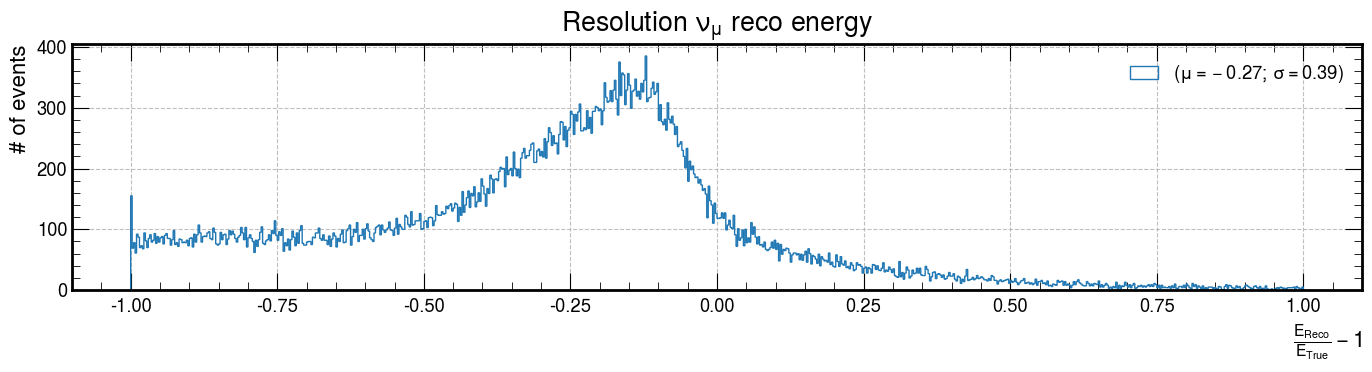

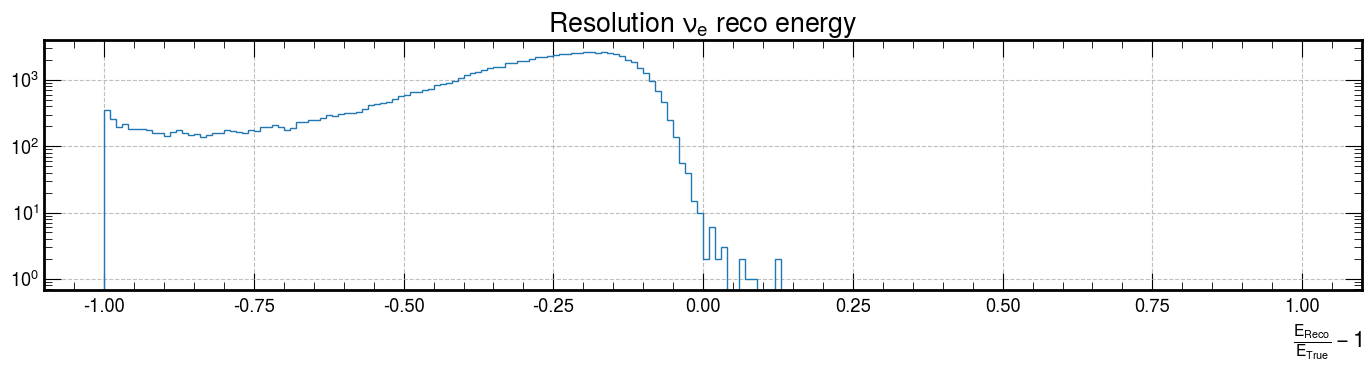

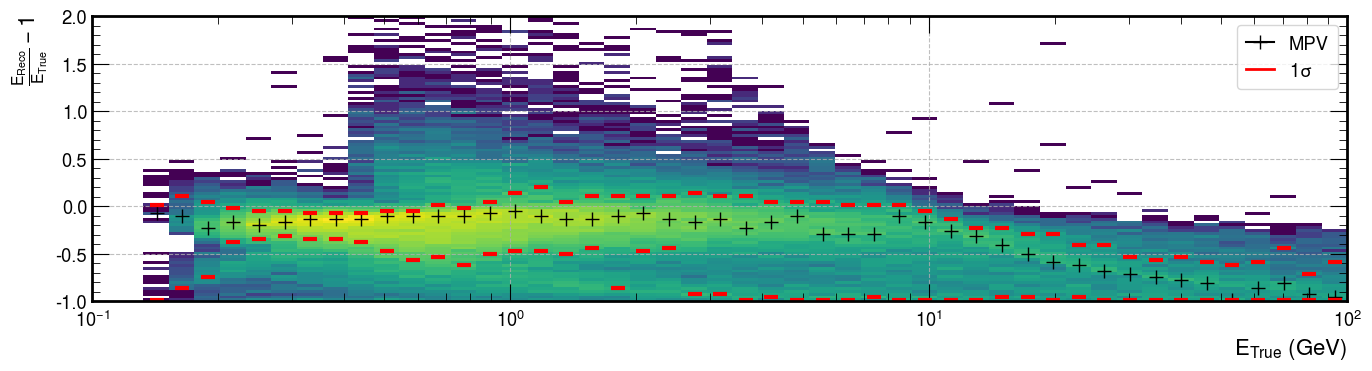

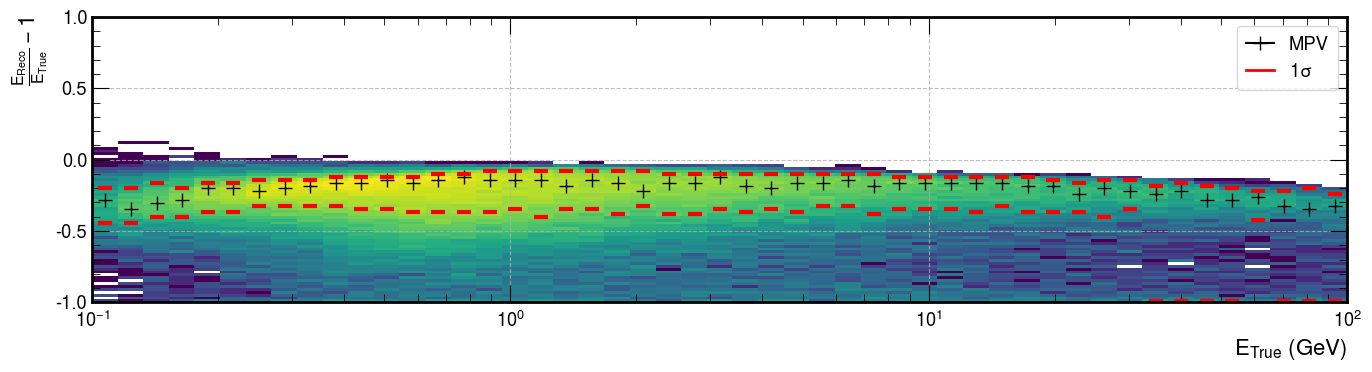

In [15]:

def flavour(pdg):
    return pl.col('rec.nuPDG').abs() == pdg
    # return pl.col('Flavour') == pdg

def energy():
    En = 'Ev'
    # return (pl.col(En) >=1 ) & (pl.col(En) <= 10)
    return (pl.col(En) >-999 )
def checkEnergy(df):
    E = df.with_columns(
        Ev = pl.col('rec.Ev'),
        Ev_reco = pl.col('rec.Ev_reco'),
        Ev_reco_nue = pl.col('rec.Ev_reco_nue'),
        Ev_reco_numu = pl.col('rec.Ev_reco_numu'),
        LepE = pl.col('rec.LepE')
    ).with_columns(
        Eres = pl.col("Ev_reco")/pl.col("Ev") - 1,
        Eres_nue = pl.col("Ev_reco_nue")/pl.col("Ev") - 1,
        Eres_numu = pl.col("Ev_reco_numu")/pl.col("Ev") - 1,
    )
    return E

def hist2dcred(df:pl.DataFrame, var, binsx, binsy):
    from scipy.stats import binned_statistic_2d
    fig = plt.gcf()
    H, edgex, edgey, binnumber = binned_statistic_2d(df['rec.Ev'], df[var]/df['rec.Ev']-1,None,'count', bins=(binsx,binsy))
    edxwidth = (edgex[1:]-edgex[:-1])/2
    edywidth = (edgey[1:]-edgey[:-1])/2
    edxcenter = edgex[:-1] + edxwidth
    edycenter = edgey[:-1] + edywidth
    for i in range(len(H)):
        if max(H[i,:]) > 1:
            hist_cred =  get1Dcred(H[i,:], 0.68)
            min_cred = 0
            max_cred = 0
            mode_cred = 0
            if len(hist_cred)!=0:
                min_cred = min(hist_cred)
                max_cred = max(hist_cred)
                mode_cred = hist_cred[0]
            plt.plot(edxcenter[i], edycenter[mode_cred], '+', mew=1, markersize=10, color='black')
            plt.plot(edxcenter[i], edycenter[min_cred], '_', mew=3, markersize=10, color='red')
            plt.plot(edxcenter[i], edycenter[max_cred], '_', mew=3, markersize=10, color='red')
        else:
            pass

    custom_label = [
        plt.Line2D([0],[0], color='black',marker='+', markersize=10, mew=1, label='MPV'),
        plt.Line2D([0],[0],lw=2, color='red',  label=r'1$\sigma$'),
        ]
    plt.legend(frameon=True, handles=custom_label)

E = checkEnergy(dfnew)
Eold = checkEnergy(dfold)
fig, ax = plt.subplots(1,1,figsize=(14,4))
binsmu = 400
binsmu_z = 800
binse = 200

limmu = 400
limmu_z = 1
lime = 1

E = E.filter(energy()).filter(pl.col('rec.isCC')==1)
Ep = E.filter(flavour(14))['Eres_numu']
stddev = np.std(Ep.to_numpy())
avg = np.mean(Ep.to_numpy())
label = rf"($\mu={avg:.2f}$; $\sigma={stddev:.2f}$)"
ax.hist(Ep, bins=binsmu_z, range=(-1,limmu_z), log=False, histtype='step', label=label);
# ax.hist(Eold.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=binsmu_z, range=(-1,limmu_z), log=False, histtype='step', label='Longest track or shower');
ax.set_title(r'Resolution $\nu_\mu$ reco energy')
ax.set_xlabel(r'$\frac{E_{Reco}}{E_{True}} - 1$')
ax.set_ylabel(r'# of events')
ax.legend()

plt.figure(figsize=(14, 4))
Ep  = E.filter(flavour(12))['Eres_nue']
stddev = np.std(Ep.to_numpy())
avg = np.mean(Ep.to_numpy())
label = rf"($\mu={avg:.2f}$; $\sigma={stddev:.2f}$)"
plt.hist(Ep, bins=binse, range=(-1, lime),log=True, histtype='step', label='');
# plt.hist(Eold.filter(flavour(12)).filter(pl.col('rec.isCC')==1).filter(energy(12))['Eres_nue'], bins=200, range=(-1, lime),log=True, histtype='step', label='HD AV');
plt.title(r'Resolution $\nu_e$ reco energy')
plt.xlabel(r'$\frac{E_{Reco}}{E_{True}} - 1$')
plt.legend()

plt.figure(figsize=(14,4))
E_sel = E.filter(flavour(14))
binse=np.logspace(-1,2,50)
binsres = np.linspace(-1,2,100)
plt.hist2d(E_sel['rec.Ev'], E_sel['rec.Ev_reco_numu']/E_sel['rec.Ev']-1,bins=[binse, binsres], norm='log');
hist2dcred(E_sel, var='rec.Ev_reco_numu', binsx=binse, binsy=binsres)
# ax.hist(Eold.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=binsmu_z, range=(-1,limmu_z), log=False, histtype='step', label='Longest track or shower');
ax = plt.gca()
ax.set_ylabel(r'$\frac{E_{Reco}}{E_{True}} - 1$')
ax.set_xlabel(r'$E_{True}$ (GeV)')
ax.set_xscale('log')

plt.figure(figsize=(14,4))
E_sel = E.filter(flavour(12))
binse=np.logspace(-1,2,50)
binsres = np.linspace(-1,1,100)
plt.hist2d(E_sel['rec.Ev'], E_sel['rec.Ev_reco_nue']/E_sel['rec.Ev']-1,bins=[binse, binsres], norm='log');
hist2dcred(E_sel, var='rec.Ev_reco_nue', binsx=binse, binsy=binsres)
# ax.hist(Eold.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=binsmu_z, range=(-1,limmu_z), log=False, histtype='step', label='Longest track or shower');
ax = plt.gca()
ax.set_ylabel(r'$\frac{E_{Reco}}{E_{True}} - 1$')
ax.set_xlabel(r'$E_{True}$ (GeV)')
ax.set_xscale('log')




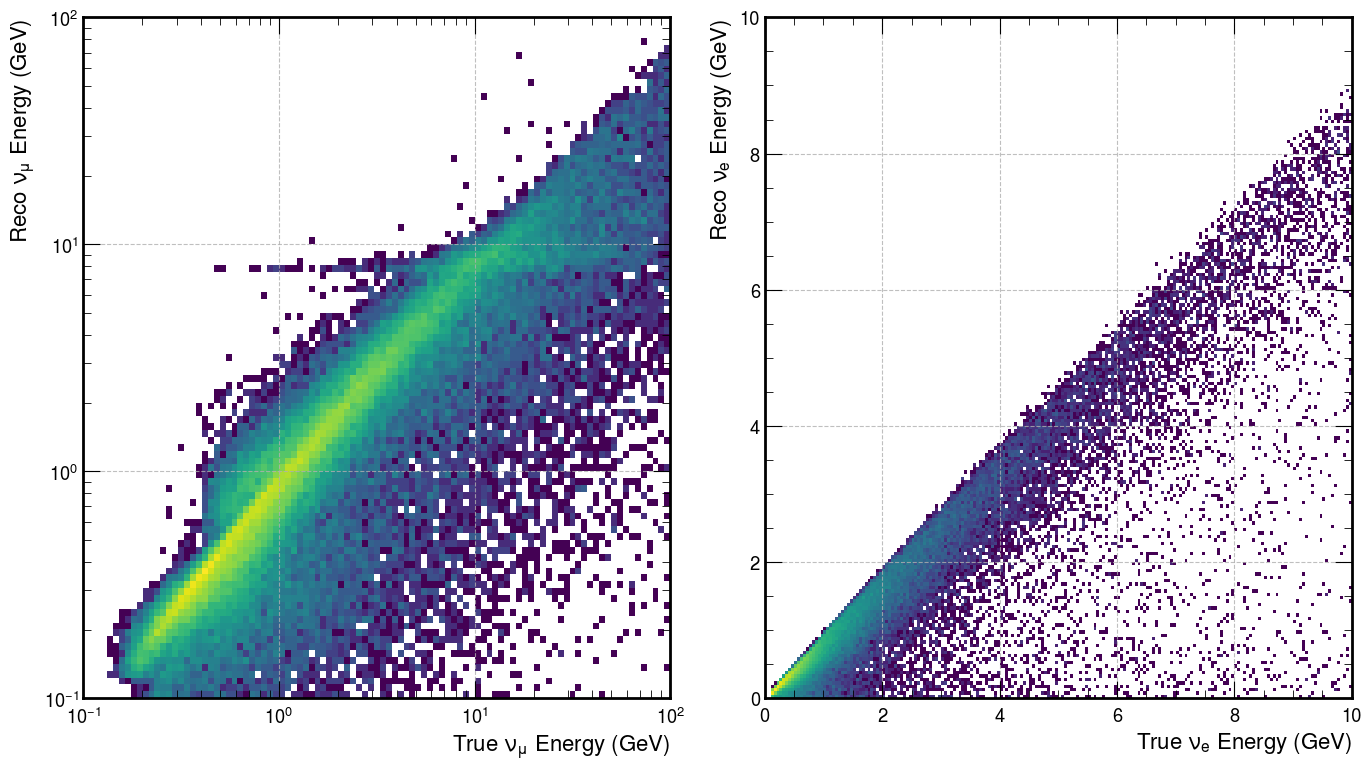

In [87]:
Enew = dfnew
Emu = Enew.filter(flavour(14)).filter(pl.col('rec.isCC')==1)#.filter(energy(14))#.filter(pl.col('rec.LongestTrackContNumu') != -1)
Ee = Enew.filter(flavour(12)).filter(pl.col('rec.isCC')==1)#.filter(energy(12))
ax:plt.Axes
binsx = np.logspace(-1,np.log10(100),100)
binsy = np.logspace(-1,np.log10(100),100)
# binsx = np.linspace(-1,20,200)
# binsy = np.linspace(-1,20,200)
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].hist2d(Emu['rec.Ev'], Emu['rec.Ev_reco_numu'], bins=(binsx,binsy), range=((0,10),(0,10)), norm = LogNorm())
ax[0].set_xlabel(rf'True {flavours[14].name_latex} Energy (GeV)')
ax[0].set_ylabel(rf'Reco {flavours[14].name_latex} Energy (GeV)')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].hist2d(Ee['rec.Ev'], Ee['rec.Ev_reco_nue'], bins=(200,200), range=((0,10),(0,10)), norm = LogNorm());
ax[1].set_xlabel(rf'True {flavours[12].name_latex} Energy (GeV)')
ax[1].set_ylabel(rf'Reco {flavours[12].name_latex} Energy (GeV)')
plt.show()

0.3374130980896185


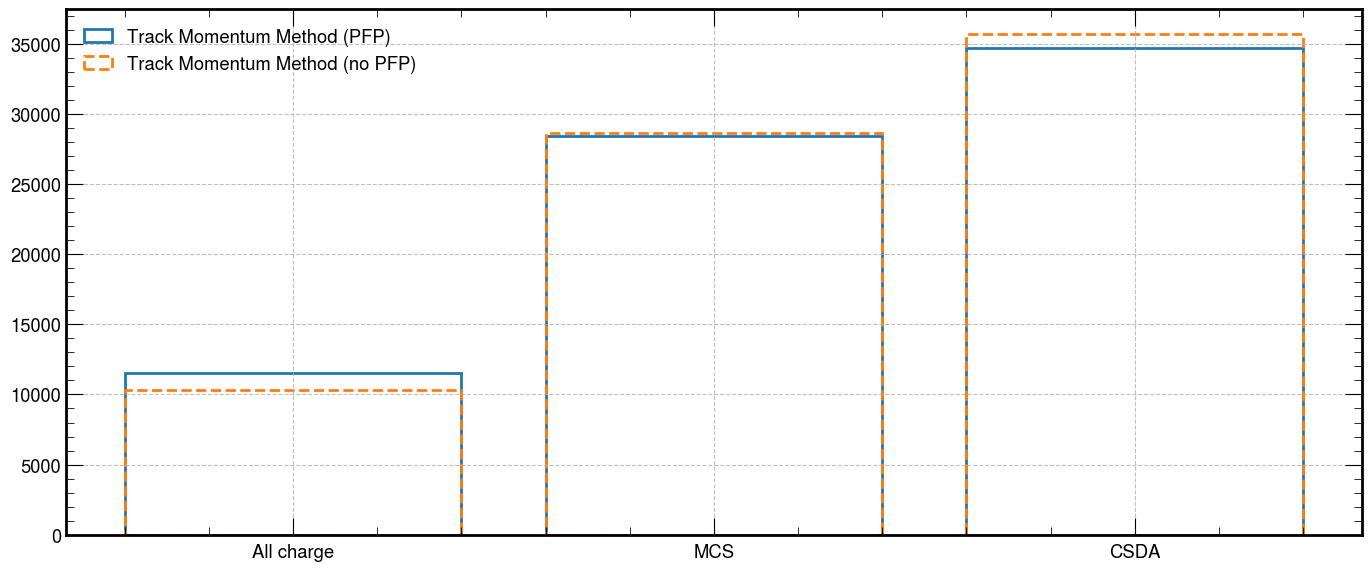

In [357]:
def make_plot(ax:plt.Axes, val:str, df:pl.DataFrame, **kwargs):
    df = df.filter(pl.col('rec.isCC') == 1).filter(flavour(14))
    dfcount = df.groupby(val).agg(
        count=pl.col(val).count()
    ).sort(val)
    methods = ['All charge', 'MCS', 'CSDA']
    ax.bar(methods, dfcount['count'], fill=False, **kwargs)
    # ax.set_xlabel(val)
    # ax.set_ylabel('# of events')
fig, axs = plt.subplots(1,1,figsize=(14,6))
# make_plot(axs, 'rec.LongestTrackContNumu', dfnew, label = 'Longest track contained (PFP)', linestyle='-', linewidth=2)
# make_plot(axs, 'rec.LongestTrackContNumu', dfold, label = 'Longest track contained (no PFP)', linestyle='--', linewidth=2)
make_plot(axs, 'rec.TrackMomMethodNumu', dfnew, label = 'Track Momentum Method (PFP)', linestyle='-', linewidth=2, edgecolor='C0')
make_plot(axs, 'rec.TrackMomMethodNumu', dfold, label = 'Track Momentum Method (no PFP)', linestyle='--', linewidth=2, edgecolor='C1')
plt.legend()

df=dfnew.filter(pl.col('rec.isCC') == 1).filter(flavour(14))
total_mcs_notC = len(df.filter(pl.col('rec.LongestTrackContNumu')==0)['rec.TrackMomMethodNumu'])
total_by_charge = len(df.filter(pl.col('rec.LongestTrackContNumu')==-1)['rec.TrackMomMethodNumu'])
print(total_by_charge/(total_mcs_notC+ total_by_charge))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


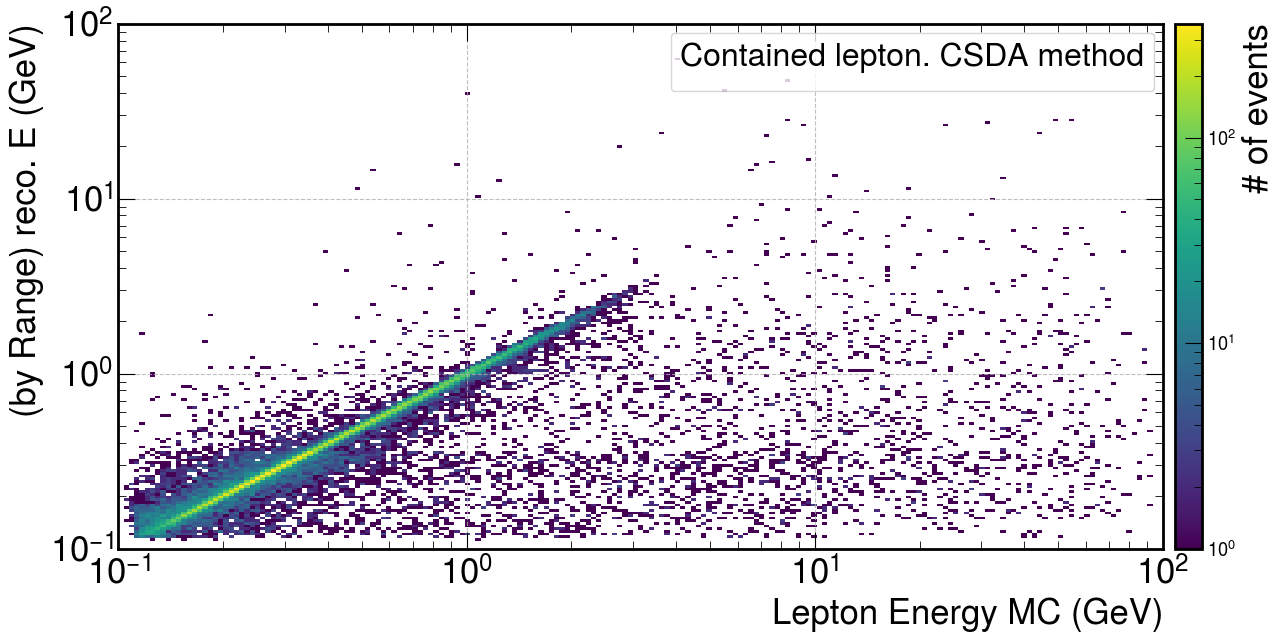

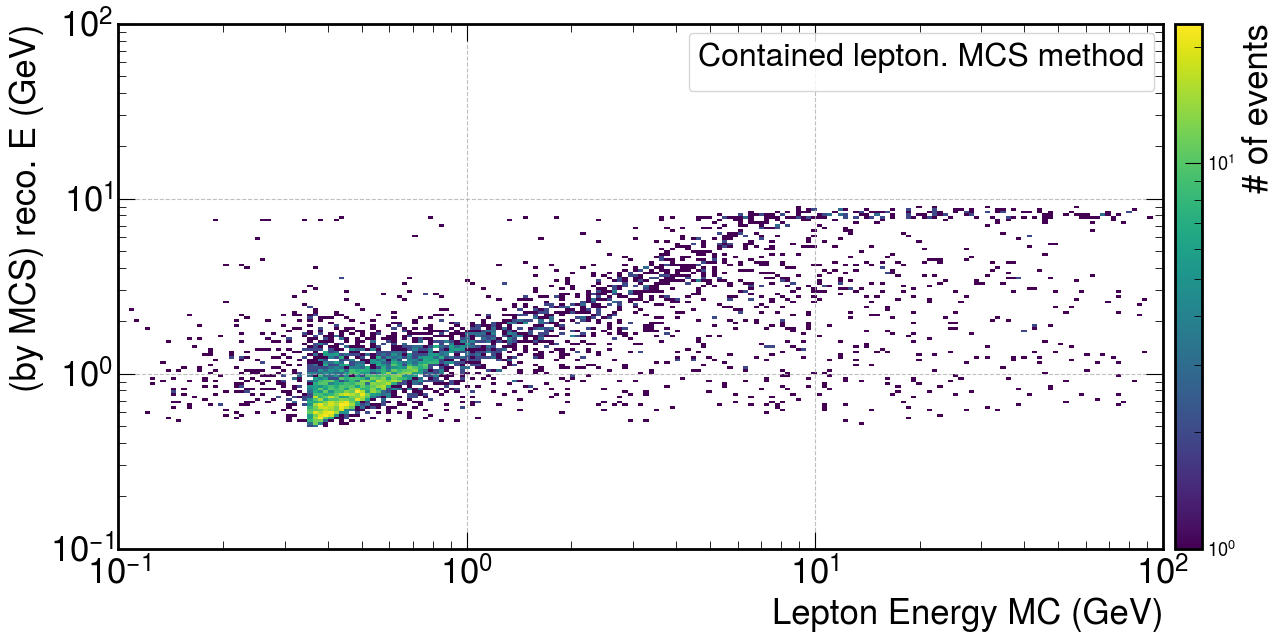

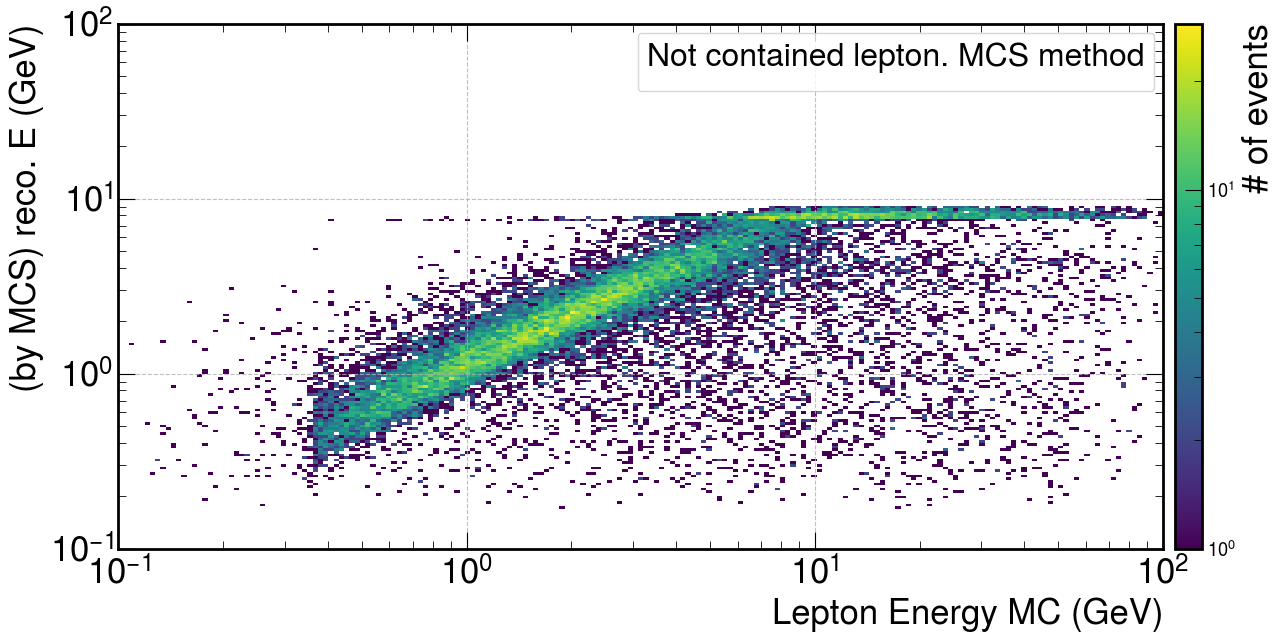

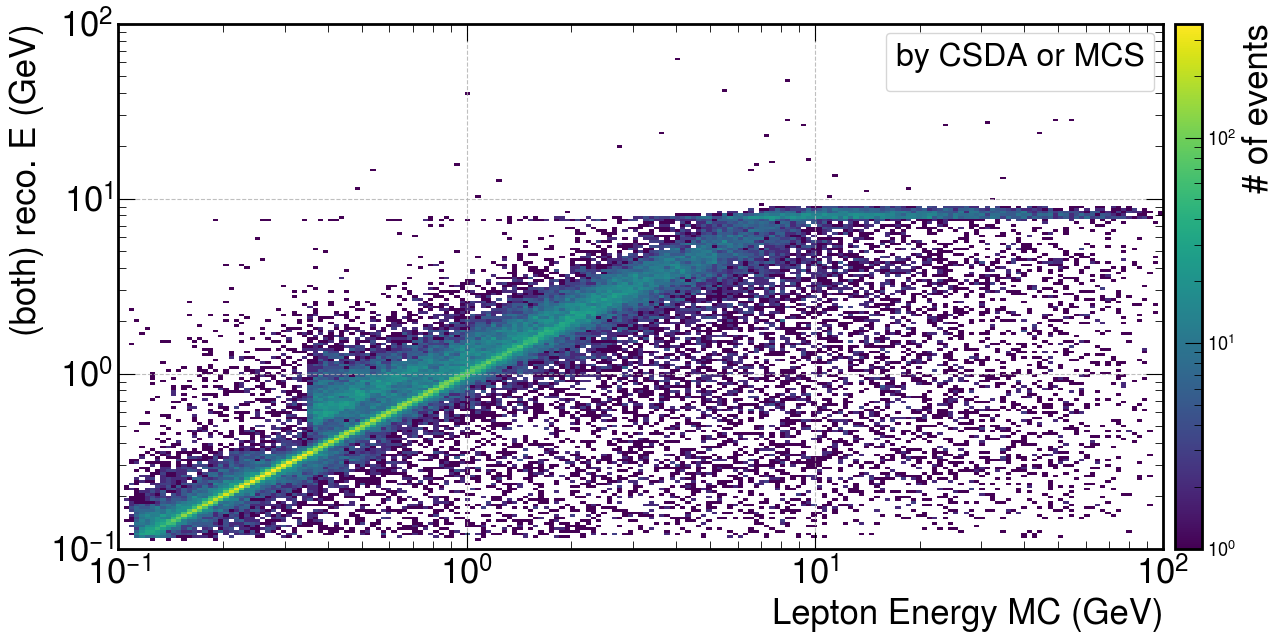

In [25]:
import matplotlib
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        v_ext = np.max( [ np.abs(self.vmin), np.abs(self.vmax) ] )
        x, y = [-v_ext, self.midpoint, v_ext], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
E = checkEnergy(dfnew)
Enew = dfnew
Enew = Enew.filter(flavour(14)).filter(pl.col('rec.isCC')==1)#.filter(pl.col('rec.LongestTrackContNumu') != -1)
# plt.plot(df.filter(pl.col('rec.nuPDG')==14).filter(pl.col('rec.isCC')==1)['rec.RecoHadEnNumu'])
def plot_mu_vs_mu(Emu:pl.DataFrame, label, lmethod, diff=False):

    fig = plt.figure(figsize=(14,6.7))
    binsx = np.logspace(-1,2,200)
    binsx2 = np.linspace(-0.5,2,50)
    fontsize=25
    if diff==True:
        binsx = np.logspace(-1,2,50)
        x = Emu['rec.LepE']
        y1 = Emu['rec.RecoLepEnNumu']
        y2 = Emu['rec.RecoLepEnNumu_old']
        h1, xedges, yedges = np.histogram2d(x, y1, bins=(binsx,binsx))
        h2, xedges, yedges = np.histogram2d(x, y2, bins=(binsx,binsx))

        cvals = (h1-h2).ravel()
        elev_min= min(cvals-5)
        elev_max= max(cvals+5)
        mid_val=0
        cmap=matplotlib.cm.RdBu_r # set the colormap to soemthing diverging

        plt.pcolormesh(xedges, yedges, (h1-h2).T,
                            cmap=cmap,
                            norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max),
                            );
        plt.xlabel('Lepton Energy MC (GeV)', fontsize=fontsize)
        plt.ylabel(f'{label} reco. E (GeV)', fontsize=fontsize)
                            
    else:
        plt.hist2d(Emu['rec.LepE'],Emu['rec.RecoLepEnNumu'], bins=(binsx,binsx), norm=LogNorm());
        plt.xlabel('Lepton Energy MC (GeV)', fontsize=fontsize)
        plt.ylabel(f'{label} reco. E (GeV)', fontsize=fontsize)

    plt.yscale('log')
    plt.xscale('log')
    plt.tick_params(labelsize=fontsize)

    cbar = plt.colorbar(pad=0.01)
    if diff:
        cbar.ax.set_ylabel('Difference (with - without PFP)', fontsize=fontsize)
        cbar.ax.tick_params(labelsize=20)
    else: cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    
    legend = plt.legend(frameon=True, title=lmethod, loc='upper right')
    plt.setp(legend.get_title(),fontsize='x-large')

# plot_mu_vs_mu(Emu.filter(pl.col('rec.LongestTrackContNumu')==1), label='(old)')
plot_mu_vs_mu(Enew.filter(pl.col('rec.LongestTrackContNumu')==1).filter(pl.col('rec.TrackMomMethodNumu')==1), label='(by Range)', lmethod='Contained lepton. CSDA method')
plot_mu_vs_mu(Enew.filter(pl.col('rec.LongestTrackContNumu')==1).filter(pl.col('rec.TrackMomMethodNumu')==0), label='(by MCS)', lmethod='Contained lepton. MCS method')
plot_mu_vs_mu(Enew.filter(pl.col('rec.LongestTrackContNumu')==0).filter(pl.col('rec.TrackMomMethodNumu')==0), label='(by MCS)', lmethod='Not contained lepton. MCS method')
plot_mu_vs_mu(Enew.filter(pl.col('rec.LongestTrackContNumu')!=-1).filter(pl.col('rec.TrackMomMethodNumu')!=-1), label='(both)', lmethod='by CSDA or MCS')
# plot_mu_vs_mu(Enew.filter(pl.col('rec.TrackMomMethodNumu')==-1), label='(both)')

In [18]:
dfu = dfnew.join(dfold, on=['rec.subrun', 'rec.event'], how='inner', suffix="_old")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


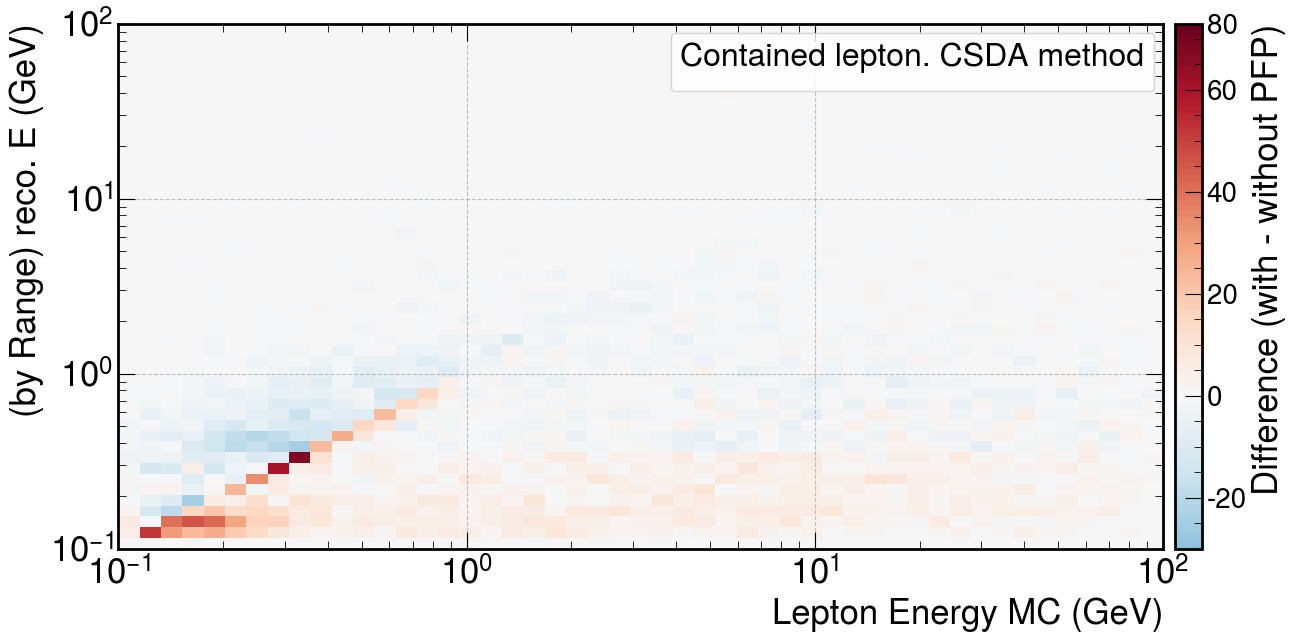

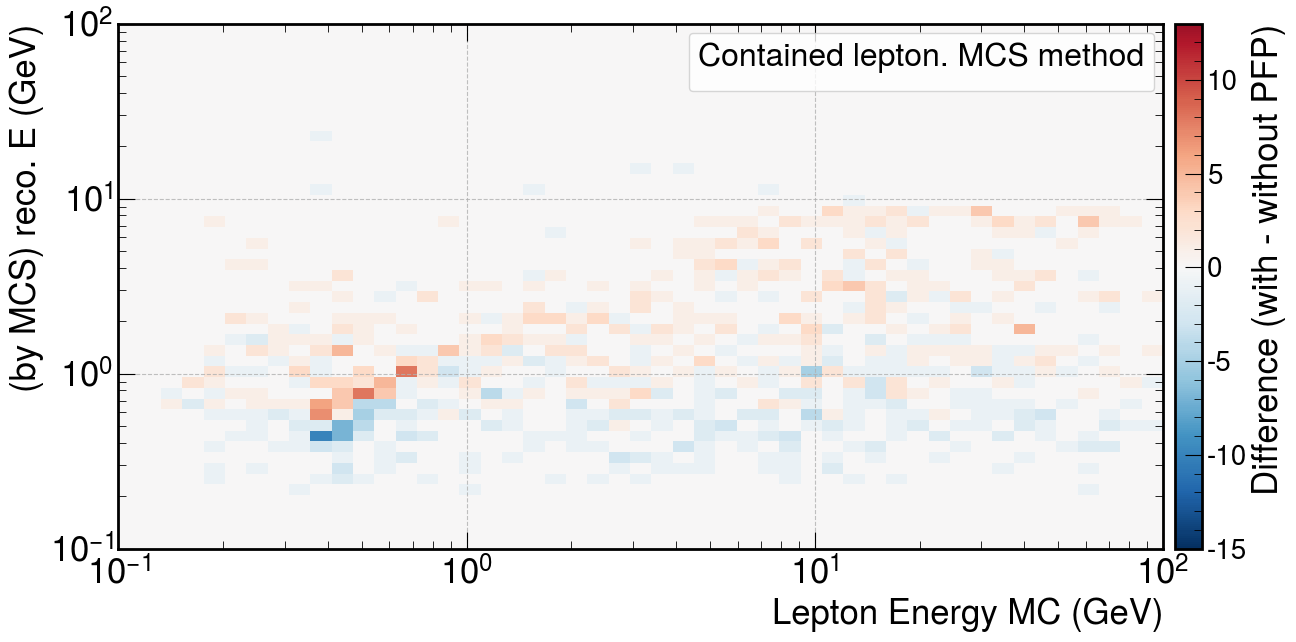

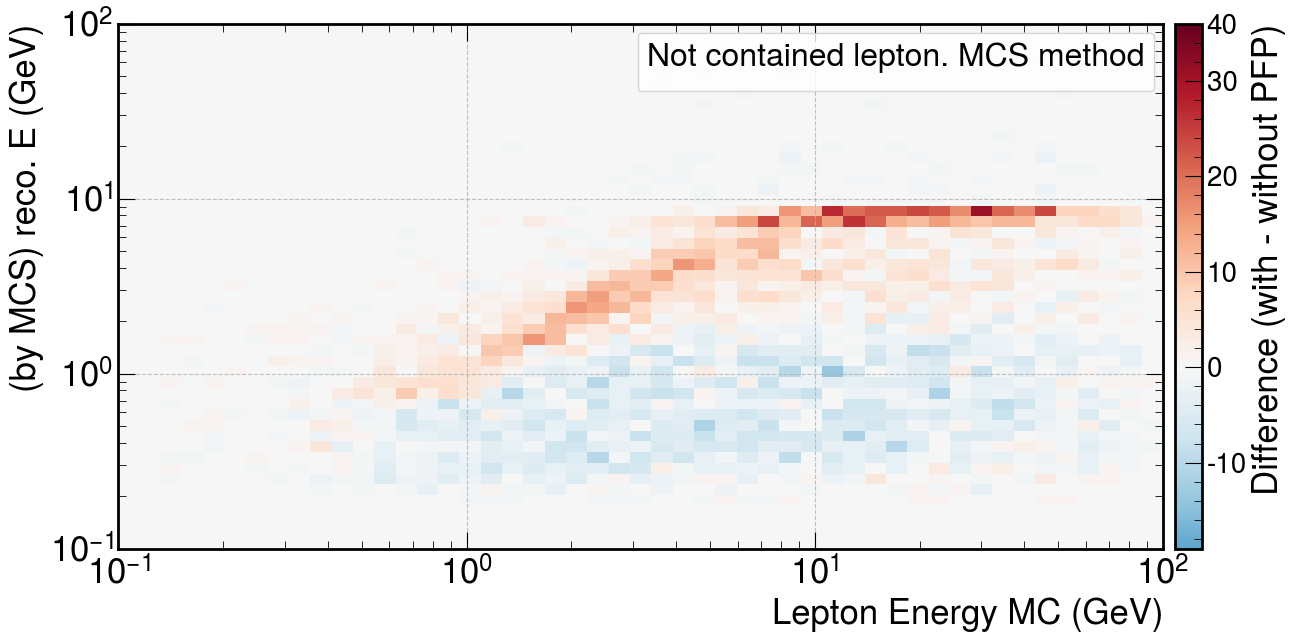

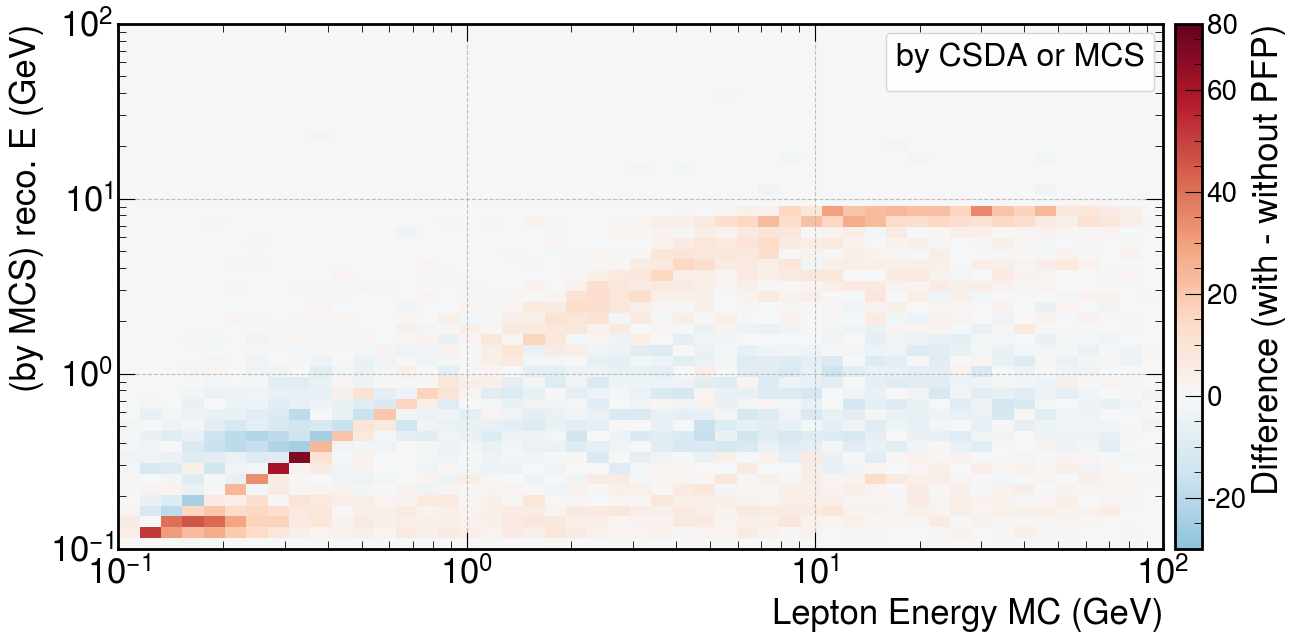

In [26]:

Enew = dfu.filter(flavour(14)).filter(pl.col('rec.isCC')==1)#.filter(pl.col('rec.LongestTrackContNumu') != -1)
plot_mu_vs_mu(Enew.filter(pl.col('rec.LongestTrackContNumu')==1).filter(pl.col('rec.TrackMomMethodNumu')==1), label='(by Range)', lmethod='Contained lepton. CSDA method', diff=True)
plot_mu_vs_mu(Enew.filter(pl.col('rec.LongestTrackContNumu')==1).filter(pl.col('rec.TrackMomMethodNumu')==0), label='(by MCS)', lmethod='Contained lepton. MCS method', diff=True)
plot_mu_vs_mu(Enew.filter(pl.col('rec.LongestTrackContNumu')==0).filter(pl.col('rec.TrackMomMethodNumu')==0), label='(by MCS)', lmethod='Not contained lepton. MCS method', diff=True)
plot_mu_vs_mu(Enew.filter(pl.col('rec.LongestTrackContNumu')!=-1).filter(pl.col('rec.TrackMomMethodNumu')!=-1), label='(by MCS)', lmethod='by CSDA or MCS', diff=True)